<a href="https://colab.research.google.com/github/Kona-O/topiary/blob/main/seed_to_alignment_advanced.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Seed to alignment pipeline

The seed_to_alignment function takes a seed dataframe (see documentation), BLASTs to find sequence hits, performs quality control, lowers alignment redundancy in a taxonomically informed fashion, and generates an alignment. This notebook offers users the option to manipulate arguments fed into each step of this part of the pipeline.

In [ ]:
import topiary

from topiary._private import installed
from topiary._private import check

import numpy as np
import pandas as pd

import random
import string
import os
import shutil

The first code block below initiates the entire seed_to_aligment pipeline with default parameters set. Users can change the parameters here. Alternatively, the subsequent code blocks break this pipeline into its separate sections for step-specific manipulations.

In [ ]:
# Pipeline that takes a seed dataframe, BLASTs to find sequence hits,
# performs quality control, lowers alignment redundancy in a taxonomically
# informed fashion, and generates an alignment.
df = seed_to_alignment(seed_df,
                      out_dir=None,
                      seqs_per_column=1,
                      max_seq_number=500,
                      redundancy_cutoff=0.90,
                      worst_align_drop_fx=0.1,
                      sparse_column_cutoff=0.80,
                      align_trim=(0.05,0.95),
                      ncbi_blast_db=None,
                      local_blast_db=None,
                      blast_xml=None,
                      move_mrca_up_by=2,
                      local_recip_blast_db=None, 
                      min_call_prob=0.95,
                      partition_temp=1,
                      hitlist_size=5000,
                      e_value_cutoff=0.001,
                      gapcosts=(11,1),
                      num_ncbi_blast_threads=1,
                      num_local_blast_threads=-1,
                      restart=False,
                      overwrite=False,
                      keep_recip_blast_xml=False,
                      verbose=False)
topiary.write_dataframe(df,"alignment.csv")

### Argument definitions and default parameters for reference: 
----------
**seed_df** : *pandas.DataFrame or str*
<br> Dataframe with at least four columns: name, species, sequence, and aliases. See documentation on seed dataframes for details.
out_dir : str, optionaloutput directory. If not specified, create an output directory with the format "seed_to_alignment_{randomletters}".

**seqs_per_column** : *float, default=1*
<br> Aim to have this number of sequences per column in the key species sequences. (For example, if the key sequence is 100 amino acids long, seqs_per_column=1 would aim for 100 sequences; 2 would aim for 200 sequences).

**max_seq_number** : *int, default=500*
<br> Maximum number of sequences to get, regardless of seqs_per_column and key sequence length.

**redundancy_cutoff** : *float, default=0.90*
<br> Merge sequences from closely related species with sequence identity above cutoff.

**worst_align_drop_fx** : *float, default=0.1*
<br> After alignment, drop approximately this fraction of the sequences, selecting those that have long insertions and are missing chunks of sequences.

**sparse_column_cutoff** : *float, default=0.80*
<br> When checking alignment quality, a column is sparse if it has gaps in more than sparse_column_cutoff sequences.

**align_trim** : *tuple, default=(0.05,0.95)*
<br> When checking alignment quality, do not score the first and last parts of the alignment. Interpreted like a slice, but with percentages. (0.0,1.0) would not trim; (0.05,0,98) would trim the first 0.05 off the front and the last 0.02 off the back.
<br>
<br>

**ncbi_blast_db** : *str, optional*
<br> NCBI blast database to use. (If ncbi_blast_db, local_blast_db and blast_xml are all None, ncbi_blast_db is automatically set to "nr").

**local_blast_db** : *str, optional*
<br> Local blast database to use.

**blast_xml** : *str or list, optional*
<br> Previously generated blast xml files to load. This argument can be:
+ single xml file (str)
+ list of xml files (list of str)
+ directory (str). Code will grab all .xml files in the directory.
<br>

**move_mrca_up_by** : *int, default=2*
<br> When inferring the phylogenetic context from the seed dataframe, get the most recent common ancestor of the seed species, then find the taxonomic rank "move_mrca_up_by" levels above that ancestor. For example, if the key species all come from marsupials (Theria) and move_mrca_up_by == 2, the context will be Amniota (Theria -> Mammalia -> Amniota).

**local_recip_blast_db** : *str, optional*
<br> Local blast database to use for reciprocal blast. If None, construct a reciprocal blast database by downloading the proteomes of the key species from the NCBI.

**min_call_prob** : *float, default=0.95*
<br> Hits from all paralogs that yield a regular expression match to one of the aliases from the seed dataframe are weighted by their relative blast bit scores. Each paralog is assigned a relative probability. This cutoff is the minimum probability the best paralog match must have to result in a paralog call. Value should be between 0 and 1 (not inclusive), where increasing min_call_prob increases the stringency.

**partition_temp** : *float, default=1*
<br> When calculating posterior probability of the reciprocal blast paralog call, use this for weighting: 2^(bit_score/partition_temp). partition_temp should be a float > 0. A higher value corresponds to a higher stringency. (The bit score difference between the best hit and the bit scores of other hits would have to be higher to be significant). This is a minium value. It may be adjusted automatically to avoid numerical problems in the calculation.
<br>
<br>
**hitlist_size** : *int, default=5000*
<br> Download only the top hitlist_size hits in initial blast.

**e_value_cutoff** : *float, default=0.001*
<br> Only take hits with e_value better than e_value_cutoff in initial blast
gapcost : tuple, default=(11,1) BLAST gapcosts (length 2 tuple of ints) in initial blast
num_ncbi_blast_threads : int, default=1 number of threads to use for NCBI blast. -1 means use all available. (Multithreading rarely speeds up remote BLAST).

**num_local_blast_threads** : *int, default=-1*
<br> Number of threads to use for local blast. -1 means all available.
<br>
<br>
**restart** : *bool, default=False*
<br> Restart job from where it stopped in output directory. incompatible with overwrite.

**overwrite** : *bool, default=False*
<br> Overwrite out_dir if it already exists. incompatible with restart.

**keep_recip_blast_xml** : *bool, default=False*
<br> Whether or not to keep raw blast xml output.

**verbose** : *bool, default=False*
<br> Verbosity of output.
<br>
<br>
Returns
----------
**topiary_dataframe** : *pandas.DataFrame*
<br> Topiary dataframe with aligned, quality-controlled sequences.

----------

# 00. Initial dataset construction

First, we create an initial dataset of sequences by BLASTing sequences from the seed dataframe against the NCBI non-redundant protein sequence database or a database of the user's choice. The taxonomic scope is given by the taxonomic rank that encompasses the key species from the seed dataset, plus a user-defined expansion (set to 2 by default). By default, topiary pulls down up to 5,000 hits per seed with an intentionally generous e-value cutoff of 0.001. (Users have full control over the BLAST search parameters.)

### Arguments definitions and default parameters used in this step:

+ **seed_df** : *pandas.DataFrame or str* 
<br> Dataframe with at least four columns: name, species, sequence,and aliases. See documentation on seed dataframes for details.
+ **ncbi_blast_db** : *str, optional*
<br> NCBI blast database to use. (If ncbi_blast_db, local_blast_db and blast_xml are all None, ncbi_blast_db is automatically set to "nr").
+ **local_blast_db** : *str, optional* 
<br> Local blast database to use.
+ **blast_xml** : *str or list, optional*
<br> Previously generated blast xml files to load. This argument can be:
     + single xml file (str)
     + list of xml files (list of str)
     + directory (str). Code will grab all .xml files in the directory.
+ **move_mrca_up_by** : *int, default=2*
<br> When inferring the phylogenetic context from the seed dataframe, get the most recent common ancestor of the seed species, then find the taxonomic rank "move_mrca_up_by" levels above that ancestor. For example, if the key species all come from marsupials (Theria) and move_mrca_up_by == 2, the context will be Amniota (Theria -> Mammalia -> Amniota).
+ **hitlist_size** : *int, default=5000*
<br> Download only the top hitlist_size hits in initial blast.
+ **e_value_cutoff** : *float, default=0.001*
<br> Only take hits with e_value better than e_value_cutoff in initial blast.
+ **gapcost** : *tuple, default=(11,1)*
<br> BLAST gapcosts (length 2 tuple of ints) in initial blast.
+ **num_ncbi_blast_threads** : *int, default=1*
<br> Number of threads to use for NCBI blast. -1 means use all available. (Multithreading rarely speeds up remote BLAST).
+ **num_local_blast_threads** : *int, default=-1*
<br> Number of threads to use for local blast. -1 means all available.
+ **keep_blast_xml** : *bool, default=True*     **--not in code definition?**
<br> Whether or not to keep raw blast xml output.

In [ ]:
# Building initial topiary dataframe.
kwargs = {"seed_df":seed_df,
          "ncbi_blast_db":ncbi_blast_db,
          "local_blast_db":local_blast_db,
          "blast_xml":blast_xml,
          "move_mrca_up_by":move_mrca_up_by,
          "hitlist_size":hitlist_size,
          "e_value_cutoff":e_value_cutoff,
          "gapcosts":gapcosts,
          "num_ncbi_blast_threads":num_ncbi_blast_threads,
          "num_local_blast_threads":num_local_blast_threads,
          "keep_blast_xml":True}

df, key_species, paralog_patterns = topiary.df_from_seed(**kwargs)
topiary.write_dataframe(df,"00_initial-dataframe.csv")

# 01. Identify each hit by reciprocal BLAST

Once the initial dataset is constructed, topiary identifies each hit by reciprocal BLAST. It downloads proteomes for the key species in the seed dataset and constructs a combined local BLAST database. It then uses the hits above as queries against the key species BLAST database, searching the resulting reciprocal hits for text descriptions that match the aliases specified in the seed dataset. (See Protocol for details about defining aliases). It weights each hit by 2s/t where s is the BLAST bit score, and t is a user-defined parameter (default = 1). Finally, topiary calculates the posterior probability that the sequence is a given paralog by calculating the sum of the weights for all reciprocal hits that match a paralog alias and then dividing by the sum of the weights from all reciprocal hits (Frith MC, 2019). ## ***A sequence is assigned a paralog identity based on a user-defined stringency cutoff (default = 0.95).*** Multiple paralogs may be assigned if the sum of their posterior probabilities is above the cutoff. If the sequence does not pull up a hit in this reciprocal BLAST step, it will be removed from future steps of the pipeline.
<br>
<br>
### Arguments definitions and default parameters used in this step:

+ **df** : *pandas.DataFrame or str*
<br> Topiary data frame or csv written out from topiary df.
+ **paralog_patterns = paralog_patterns**
<br> XX_not exactly sure what this is... a column that should be in the dataframe?
+ **local_blast_db = local_recip_blast_db** : *str, optional*
<br> Local blast database to use for reciprocal blast. If None, construct a reciprocal blast database by downloading the proteomes of the key species from the ncbi.
+ **num_threads = num_local_blast_threads** : *int, default=-1*
<br> Number of threads to use for local blast. -1 means all available.
+ **keep_blast_xml = keep_recip_blast_xml** : *bool, default=False*
<br> Whether or not to keep raw blast xml output.

In [ ]:
# Doing reciprocal blast.
df = topiary.recip_blast(df,
                        paralog_patterns=paralog_patterns,
                        local_blast_db=local_recip_blast_db,
                        num_threads=num_local_blast_threads,
                        keep_blast_xml=keep_recip_blast_xml)

topiary.write_dataframe(df,"01_recip-blast-dataframe.csv")

# 02. Redundancy reduction, quality control, and alignment

This BLAST approach typically finds many more sequences than are necessary or practical for a standard phylogenetic analysis. We must therefore select sequences that sample the diversity in the dataset without compromising our ability to infer ancestors. Topiary selects a subset of sequences using a combination of taxonomy, sequence identity, and sequence quality. By default, topiary aims to build an alignment with approximately one sequence per site in the average length of seed sequences. If our seed sequences were 100 amino acids long, topiary would try to build an alignment with 100 sequences. This prevents over-fitting and makes later computational steps faster. (Users can change the target alignment size if desired).
Topiary uses four strategies (outlined in detail in the documentation) to decrease the size of the dataset while maintaining dataset quality. First, sequences defined in the initial seed dataset are kept, regardless of their quality score or redundancy. Second, topiary selects sequences based on their placement on the species tree rather than solely based on their identity. Third, when merging blocks of similar sequences, topiary preferentially keeps sequences that align well to the seed sequences. Fourth and finally, there are a few steps where topiary lowers redundancy based on shared sequence identity.

The full quality control and redundancy reduction steps incorporating the strategies summarized above are as follows. All parameters have useful default values but can be adjusted by users.
1. Remove sequences from species that cannot be resolved on the most recent Open Tree of Life synthetic tree.
2. Discard sequences that do not return a seed sequence when used as reciprocal BLAST queries against proteomes from key species.
3. Remove similar sequences within each species using a sequence identity cutoff (default = 0.90). This removes isoforms and recent lineage-specific duplications.
4. Remove similar sequences taken from closely related species using a sequence identity cutoff (default = 0.90).
5. Calculate a target alignment size based on the average length of the seed sequences (typically one sequence per amino acid in the average seed length). Then multiply this by 1.1 so we can remove sequences after budgeting and still have an alignment of the desired size.
6. Using the species tree, identify blocks of sequences from closely related species using the budgeting strategy shown in the figure below. Generate an MSA for the sequences in the block plus the seed sequences, and then select the best-aligning sequence within each block.
7. Align all sequences in the current dataset, which will have ~1.1 times the target alignment size. Remove the worst aligning sequences.
a. Remove the sequences with the most characters in non-dense columns (drop worst 2.5%).
b. Remove the sequences with the most missing dense columns (drop worst 2.5%).

This yields a relatively clean dataset with ~5% more sequences than our target alignment number. We leave these extra sequences in place so we can manually delete the worst aligners upon visual inspection and still have our approximate target number of sequences.
<br>
<br>
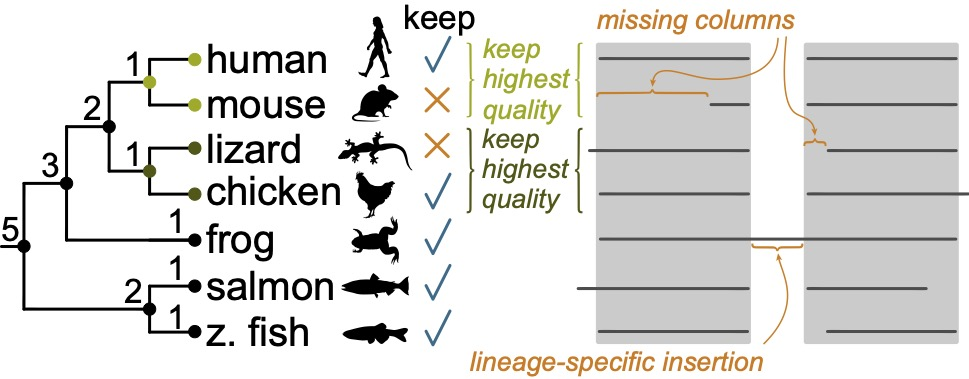
<br>
Topiary redundancy reduction and quality control. This analysis starts with seven sequences (taken from seven organisms) with the goal of retaining five for the downstream analysis. The numbers next to the ancestral nodes on the tree are the budget allocated for all descendants: 5 for all organisms, 2 for the fishes, 3 for tetrapods, etc. The “keep” column indicates which sequences are kept after the redundancy reduction step. A schematic alignment is shown on the right, with poorly aligned and missing regions labeled. The alignment quality is used to select which sequences to keep within taxonomic blocks (human/mouse and lizard/chicken, in this example).
<br>
### Arguments definitions and default parameters used in this step:

+ **df** : *pandas.DataFrame or str*
<br> Topiary data frame or csv written out from topiary df.
+ **paralog_column** : *recip_paralog*
<br> XX_not exactly sure what this is... a column that should be in the dataframe?
+ **seqs_per_column** : *float, default=1*
<br> Aim to have this number of sequences per column in the key species sequences. (For example, if the key sequence is 100 amino acids long,
seqs_per_column=1 would aim for 100 sequences; 2 would aim for 200 sequences).
+ **worst_align_drop_fx** : *float, default=0.1*
<br> After alignment, drop approximately this fraction of the sequences, selecting those that have long insertions and are missing chunks of sequences.
+ **max_seq_number** : *int, default=500*
<br> Maximum number of sequences to get, regardless of seqs_per_column and key sequence length. 
+ **redundancy_cutoff** : *float, default=0.90* 
<br> Merge sequences from closely related species with sequence identity above cutoff.
+ **sparse_column_cutoff** : *float, default=0.80*
<br> When checking alignment quality, a column is sparse if it has gaps in more than sparse_column_cutoff sequences.
+ **align_trim** : *tuple, default=(0.05,0.95)*
<br> When checking alignment quality, do not score the first and last parts of the alignment. Interpreted like a slice, but with percentages (0.0,1.0) would not trim; (0.05,0,98) would trim the first 0.05 off the front and the last 0.02 off the back.

In [ ]:
# Reducing number of sequences.
kwargs = {"df":df,
          "paralog_column":"recip_paralog",
          "seqs_per_column":seqs_per_column*(1 + worst_align_drop_fx),
          "max_seq_number":max_seq_number*(1 + worst_align_drop_fx),
          "redundancy_cutoff":redundancy_cutoff,
          "sparse_column_cutoff":sparse_column_cutoff,
          "align_trim":align_trim}

df = topiary.quality.shrink_dataset(**kwargs)
topiary.write_dataframe(df,"02_shrunk-dataframe.csv")

# 03. Alignment

Topiary uses Muscle5 with its default parameters to generate the MSA (Edgar RC, 2021). We
selected this algorithm due to its demonstrated high performance, as well as the extremely fast “super5” algorithm that is useful for generating draft alignments for large datasets. Advanced users can set all Muscle5 options. ***XXX is that going to be written out here? XXX

### Arguments definitions and default parameters used in this step:

+ **df** : *pandas.DataFrame or str*
<br> Topiary data frame or csv written out from topiary df.

In [ ]:
# Aligning sequences.
df = topiary.muscle.align(df)
topiary.write_dataframe(df,"03_clean-aligned-dataframe.csv")

# 04-05. Polish alignment and re-align

### Arguments definitions and default parameters used in this step:

+ **df** : *pandas.DataFrame or str*
<br> Topiary data frame or csv written out from topiary df.
+ **worst_align_drop_fx** : *float, default=0.1*
<br> After alignment, drop approximately this fraction of the sequences, selecting those that have long insertions and are missing chunks of sequences.
+ **fx_sparse_percential** : *(1 - worst_align_drop_fx)* XX
+ **sparse_run_percentile** : *(1 - worst_align_drop_fx)* XX
+ **fx_missing_percentile** : *(1 - worst_align_drop_fx)* XX
+ **realign** : *bool, default=True*
<br> Re-align the MSA if set to True.
+ **sparse_column_cutoff** : *float, default=0.80*
<br> When checking alignment quality, a column is sparse if it has gaps in more than sparse_column_cutoff sequences.

In [ ]:
# Polishing alignment and re-aligning.
kwargs = {"df":df,
          "fx_sparse_percential":(1 - worst_align_drop_fx),
          "sparse_run_percentile":(1 - worst_align_drop_fx),
          "fx_missing_percentile":(1 - worst_align_drop_fx),
          "realign":True,
          "sparse_column_cutoff":sparse_column_cutoff}

df = topiary.quality.polish_alignment(**kwargs)
topiary.write_dataframe(df,"04_clean-aligned-dataframe.csv")
topiary.write_fasta(df,
                    f"{step_counter:02d}_alignment.fasta",
                    seq_column="alignment",
                    label_columns=["species","recip_paralog"])

os.chdir(cwd)

pretty_name = os.path.join(out_dir,"05_clean-aligned-dataframe.csv")